# Robust04 Information Retrieval: 3-Phase Neural Reranking Pipeline

**Objective**: Build and evaluate a progressive retrieval system on the TREC Robust04 collection.

**Dataset**: 
- 249 queries total (50 with relevance judgments for training, 199 for testing)
- ~528K documents from TREC disks 4 & 5

**Methodology**: 
This notebook implements a 3-phase retrieval pipeline with systematic parameter tuning:
1. **Phase 1 - BM25 Baseline**: Traditional term-based retrieval with tuned k1 and b parameters
2. **Phase 2 - BM25 + RM3**: Query expansion using pseudo-relevance feedback (tuning fb_terms, fb_docs, original_weight)
3. **Phase 3 - BM25 + RM3 + MiniLM**: Neural reranking with MiniLM-L6 cross-encoder fine-tuned on MS MARCO (tuning rerank_k, batch_size)

**Evaluation**: 
- Metric: Mean Average Precision (MAP) on 50 training queries
- Grid search for optimal hyperparameters at each phase
- Results cached for reproducibility

**Output**: 
Three TREC-format run files (run_1.res, run_2.res, run_3.res) for the 199 test queries.

## 1. Setup & Dependencies

### 1.1. Install Required Packages

In [1]:
# !apt-get update
# !apt-get install -y openjdk-21-jdk
# !update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-21-openjdk-amd64/bin/java 1
# !update-alternatives --install /usr/bin/javac javac /usr/lib/jvm/java-21-openjdk-amd64/bin/javac 1
# !update-alternatives --set java /usr/lib/jvm/java-21-openjdk-amd64/bin/java
# !update-alternatives --set javac /usr/lib/jvm/java-21-openjdk-amd64/bin/javac

In [2]:
# !pip install matplotlib
# !pip install transformers
# !pip install sentence-transformers
# !pip install pytrec_eval
# !pip install torch torchvision torchaudio
# !pip install faiss-cpu --no-cache
# !pip install pyserini==0.36.0

In [3]:
import os
import re

import warnings
warnings.filterwarnings("ignore")

from abc import ABC, abstractmethod
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
from itertools import product
from functools import lru_cache

import numpy as np
import pandas as pd
from tqdm import tqdm
import pytrec_eval

from IPython.display import display

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader

from sentence_transformers import CrossEncoder

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ Dependencies imported")

2026-01-15 00:42:27.355786485 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


Using device: cuda
✓ Dependencies imported


### 1.2. Load Pyserini Index

In [4]:
INDEX_NAME = "robust04"

searcher = LuceneSearcher.from_prebuilt_index(INDEX_NAME)
index_reader = IndexReader.from_prebuilt_index(INDEX_NAME)

print(f"Index: {INDEX_NAME}")
print(f"Total documents: {index_reader.stats()['documents']:,}")
print(f"Total terms: {index_reader.stats()['total_terms']:,}")
print("✓ Pyserini index loaded")

Jan 15, 2026 12:42:28 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


Index: robust04
Total documents: 528,030
Total terms: 174,540,872
✓ Pyserini index loaded


## 2. Data Loading

---

**Note**: The 50 queries with qrels are used for training/tuning (parameter optimization via grid search). The remaining 199 queries without qrels are used for generating final submission files.

### 2.1. Load Queries

In [5]:
DATA_DIR = "./data/"

def load_queries(filepath: str) -> Dict[str, str]:
    """Load queries from file. Format: qid<tab>query_text"""
    queries = {}
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                qid, text = parts
                queries[qid] = text
    return queries

all_queries = load_queries(os.path.join(DATA_DIR, "queriesROBUST.txt"))

print(f"Total queries loaded: {len(all_queries)}")
print(f"\nSample queries:")
for qid, text in list(all_queries.items())[:5]:
    print(f"  {qid}: {text}")

Total queries loaded: 249

Sample queries:
  301: international organized crime
  302: poliomyelitis post polio
  303: hubble telescope achievements
  304: endangered species mammals
  305: dangerous vehicles


### 2.2. Load Relevance Judgments

In [6]:
def load_qrels(filepath: str) -> Dict[str, Dict[str, int]]:
    """Load qrels. Format: qid 0 docid relevance"""
    qrels = defaultdict(dict)
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                qid, _, docid, rel = parts[:4]
                qrels[qid][docid] = int(rel)
    return dict(qrels)

qrels = load_qrels(os.path.join(DATA_DIR, "qrels_50_Queries"))

print(f"Queries with relevance judgments: {len(qrels)}")
print(f"Total judgments: {sum(len(v) for v in qrels.values()):,}")
print(f"\nSample qrels for query 301:")
sample_rels = list(qrels.get("301", {}).items())[:5]
for docid, rel in sample_rels:
    print(f"  {docid}: {rel}")

Queries with relevance judgments: 50
Total judgments: 61,511

Sample qrels for query 301:
  FBIS3-10082: 1
  FBIS3-10169: 0
  FBIS3-10243: 1
  FBIS3-10319: 0
  FBIS3-10397: 1


### 2.3. Train/Test Split

In [7]:
train_qids = sorted(qrels.keys())
test_qids = [qid for qid in all_queries.keys() if qid not in train_qids]

train_queries = {qid: all_queries[qid] for qid in train_qids}
test_queries = {qid: all_queries[qid] for qid in test_qids}

print(f"Training queries: {len(train_queries)} (with qrels)")
print(f"Test queries: {len(test_queries)} (no qrels)")
print(f"\nTrain QIDs: {train_qids[:10]}...")
print(f"Test QIDs: {test_qids[:10]}...")

Training queries: 50 (with qrels)
Test queries: 199 (no qrels)

Train QIDs: ['301', '302', '303', '304', '305', '306', '307', '308', '309', '310']...
Test QIDs: ['351', '352', '353', '354', '355', '356', '357', '358', '359', '360']...


## 3. Evaluation Framework

---

**Evaluation Strategy**: All experiments use MAP (Mean Average Precision) computed with pytrec_eval. Grid search explores parameter combinations, caching results to avoid redundant computation. Best parameters from each phase are carried forward to the next phase.

### 3.1. Evaluation Functions

In [8]:
def compute_map(
    run: Dict[str, List[Tuple[str, float]]],
    qrels: Dict[str, Dict[str, int]]
) -> Tuple[float, Dict[str, float]]:
    """
    Compute MAP using pytrec_eval (TREC standard).

    Returns:
        map_score: float
        per_query_ap: Dict[qid, AP]
    """

    # Convert run to pytrec_eval format: {qid: {docid: score}}
    run_dict = {
        qid: {docid: score for docid, score in docs}
        for qid, docs in run.items()
    }

    # Convert qrels to pytrec_eval format: {qid: {docid: relevance}}
    qrels_dict = {
        qid: dict(docs)
        for qid, docs in qrels.items()
    }

    # --- SAFETY CHECKS (critical) ---
    missing_qids = set(qrels_dict) - set(run_dict)
    assert not missing_qids, (
        f"Missing queries in run: {sorted(list(missing_qids))[:10]}"
    )

    for qid, docs in run.items():
        docids = [d for d, _ in docs]
        assert len(docids) == len(set(docids)), (
            f"Duplicate docIDs in run for query {qid}"
        )

    # --- Evaluation ---
    evaluator = pytrec_eval.RelevanceEvaluator(qrels_dict, {"map"})
    results = evaluator.evaluate(run_dict)

    # Per-query AP
    per_query_ap = {qid: m["map"] for qid, m in results.items()}

    # Aggregate MAP exactly as TREC does
    map_score = pytrec_eval.compute_aggregated_measure(
        "map",
        list(per_query_ap.values())
    )

    return map_score, per_query_ap


def evaluate_run(
    run: Dict[str, List[Tuple[str, float]]],
    qrels: Dict[str, Dict[str, int]],
    run_name: str = "run"
) -> Dict:
    """Evaluate a run using pytrec_eval and return metrics."""
    map_score, per_query_ap = compute_map(run, qrels)
    
    return {
        "run_name": run_name,
        "map": map_score,
        "num_queries": len(per_query_ap),
        "per_query_ap": per_query_ap
    }

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 3.2. Caching Utilities

In [9]:
def get_results_csv(phase_num: int = None) -> str:
    """Get CSV filename for a specific phase."""
    if phase_num is None:
        return "./experiments.csv"
    return f"./experiments_phase{phase_num}.csv"


def generate_config_key(method: str, params: Dict) -> str:
    """Generate unique config key for caching."""
    parts = [method]
    for k, v in sorted(params.items()):
        parts.append(f"{k}={v}")
    return "__".join(parts)


def load_cached_result(config_key: str, phase_num: int = None) -> Optional[Dict]:
    """Load cached result if exists."""
    results_csv = get_results_csv(phase_num)
    
    if not os.path.exists(results_csv):
        return None
    
    df = pd.read_csv(results_csv)
    row = df[df["config_key"] == config_key]
    
    if row.empty:
        return None
    
    return row.iloc[0].to_dict()


def save_experiment_result(result: Dict, phase_num: int = None):
    """Save experiment result to phase-specific cache."""
    results_csv = get_results_csv(phase_num)
    df_row = pd.DataFrame([result])
    
    if not os.path.exists(results_csv):
        df_row.to_csv(results_csv, index=False)
    else:
        df_row.to_csv(results_csv, mode="a", header=False, index=False)


print("✓ Caching utilities defined")

✓ Caching utilities defined


### 3.3. Base Retriever Class

In [10]:
class BaseRetriever(ABC):
    """
    Abstract base class for all retrieval models.
    All models must implement search() and get_params().
    """
    
    def __init__(self, index_name: str = "robust04"):
        self.index_name = index_name
    
    @abstractmethod
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        """Search for all queries and return ranked results."""
        pass
    
    def get_params(self) -> Dict:
        """Return model parameters for logging."""
        return {}


print("✓ BaseRetriever class defined")

✓ BaseRetriever class defined


### 3.4. Experiment Framework

In [11]:
def run_experiment(
    config_key: str,
    model_name: str,
    model_class: type,
    model_params: Dict,
    queries: Dict[str, str],
    qrels: Dict[str, Dict[str, int]]
) -> Dict:
    """Run a single experiment using a retriever class."""
    model = model_class(**model_params)
    run = model.search(queries, k=1000)
    metrics = evaluate_run(run, qrels, config_key)
    
    return {
        "config_key": config_key,
        "method": model_name,
        **model.get_params(),
        "map": metrics["map"],
        "num_queries": metrics["num_queries"]
    }


def run_grid_search(
    method_name: str,
    model_class: type,
    param_grid: Dict[str, list],
    queries: Dict[str, str],
    qrels: Dict[str, Dict[str, int]],
    phase_num: int = None
) -> pd.DataFrame:
    """Grid search for retriever classes with phase-specific caching."""
    results = []
    
    # Print header
    phase_str = f"PHASE {phase_num}: " if phase_num else ""
    print("="*60)
    print(f"{phase_str}Tuning {method_name} parameters")
    print("="*60)
    print()
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    for combo in product(*param_values):
        params = dict(zip(param_names, combo))
        config_key = generate_config_key(method_name, params)
        
        # Check phase-specific cache
        cached = load_cached_result(config_key, phase_num)
        if cached is not None:
            param_str = ", ".join([f"{k}={v}" for k, v in params.items()])
            print(f"{param_str} -> MAP={cached['map']:.4f} [CACHED]")
            results.append(cached)
            continue
        
        # Run experiment
        param_str = ", ".join([f"{k}={v}" for k, v in params.items()])
        print(f"{param_str} -> Running...", end=" ")
        
        result = run_experiment(
            config_key=config_key,
            model_name=method_name,
            model_class=model_class,
            model_params=params,
            queries=queries,
            qrels=qrels
        )
        
        # Save to phase-specific cache
        save_experiment_result(result, phase_num)
        print(f"MAP={result['map']:.4f}")
        results.append(result)
    
    # Create and sort results dataframe
    df = pd.DataFrame(results).sort_values("map", ascending=False)
    
    print()
    print("="*60)
    print(f"{method_name} Tuning Results (Top 5):")
    print("="*60)
    display(df.head())
    
    return df


print("✓ Experiment framework defined")

✓ Experiment framework defined


## 4. PHASE 1: BM25 Baseline

---

**Phase 1 Overview**: BM25 is a probabilistic ranking function based on term frequency and document length normalization. We tune k1 (term frequency saturation) and b (length normalization) to find optimal retrieval parameters for Robust04.

### 4.1. BM25 Retriever Class

In [12]:
class BM25Retriever(BaseRetriever):
    """BM25 retrieval model."""
    
    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self._searcher = None
    
    @property
    def searcher(self) -> LuceneSearcher:
        if self._searcher is None:
            self._searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._searcher.set_bm25(k1=self.k1, b=self.b)
        return self._searcher
    
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results = {}
        for qid, query_text in tqdm(queries.items(), desc="BM25 Search"):
            hits = self.searcher.search(query_text, k=k)
            results[qid] = [(hit.docid, hit.score) for hit in hits]
        return results
    
    def get_params(self) -> Dict:
        return {"k1": self.k1, "b": self.b}


print("✓ BM25Retriever class defined")

✓ BM25Retriever class defined


### 4.2. Parameter Tuning

In [13]:
BM25_PARAM_GRID = {
    "k1": [0.6, 0.9, 1.2, 1.5, 2.0],
    "b": [0.3, 0.4, 0.5, 0.6, 0.75]
}

# Run grid search with BM25Retriever class
bm25_df = run_grid_search(
    method_name="BM25",
    model_class=BM25Retriever,
    param_grid=BM25_PARAM_GRID,
    queries=train_queries,
    qrels=qrels,
    phase_num=1
)

PHASE 1: Tuning BM25 parameters

k1=0.6, b=0.3 -> MAP=0.2463 [CACHED]
k1=0.6, b=0.4 -> MAP=0.2475 [CACHED]
k1=0.6, b=0.5 -> MAP=0.2453 [CACHED]
k1=0.6, b=0.6 -> MAP=0.2422 [CACHED]
k1=0.6, b=0.75 -> MAP=0.2392 [CACHED]
k1=0.9, b=0.3 -> MAP=0.2450 [CACHED]
k1=0.9, b=0.4 -> MAP=0.2455 [CACHED]
k1=0.9, b=0.5 -> MAP=0.2442 [CACHED]
k1=0.9, b=0.6 -> MAP=0.2415 [CACHED]
k1=0.9, b=0.75 -> MAP=0.2374 [CACHED]
k1=1.2, b=0.3 -> MAP=0.2426 [CACHED]
k1=1.2, b=0.4 -> MAP=0.2427 [CACHED]
k1=1.2, b=0.5 -> MAP=0.2424 [CACHED]
k1=1.2, b=0.6 -> MAP=0.2400 [CACHED]
k1=1.2, b=0.75 -> MAP=0.2334 [CACHED]
k1=1.5, b=0.3 -> MAP=0.2392 [CACHED]
k1=1.5, b=0.4 -> MAP=0.2396 [CACHED]
k1=1.5, b=0.5 -> MAP=0.2384 [CACHED]
k1=1.5, b=0.6 -> MAP=0.2360 [CACHED]
k1=1.5, b=0.75 -> MAP=0.2307 [CACHED]
k1=2.0, b=0.3 -> MAP=0.2320 [CACHED]
k1=2.0, b=0.4 -> MAP=0.2330 [CACHED]
k1=2.0, b=0.5 -> MAP=0.2324 [CACHED]
k1=2.0, b=0.6 -> MAP=0.2292 [CACHED]
k1=2.0, b=0.75 -> MAP=0.2250 [CACHED]

BM25 Tuning Results (Top 5):


,config_key,method,k1,b,map,num_queries
1,BM25__b=0.4__k1=0.6,BM25,0.6,0.4,0.247464,50
0,BM25__b=0.3__k1=0.6,BM25,0.6,0.3,0.246328,50
6,BM25__b=0.4__k1=0.9,BM25,0.9,0.4,0.245466,50
2,BM25__b=0.5__k1=0.6,BM25,0.6,0.5,0.245285,50
5,BM25__b=0.3__k1=0.9,BM25,0.9,0.3,0.244954,50


### 4.3. Validation Results

In [14]:
best_bm25 = bm25_df.iloc[0]
best_k1, best_b = best_bm25["k1"], best_bm25["b"]

print("\n" + "="*60)
print("PHASE 1 COMPLETE: Best BM25 Parameters")
print("="*60)
print(f"  k1 = {best_k1}")
print(f"  b = {best_b}")
print(f"  MAP = {best_bm25['map']:.4f}")
print("="*60)

# Create best BM25 model
bm25_model = BM25Retriever(k1=best_k1, b=best_b)
bm25_run_train = bm25_model.search(train_queries, k=1000)

print("\n✓ Best BM25 model ready for Phase 2")


PHASE 1 COMPLETE: Best BM25 Parameters
  k1 = 0.6
  b = 0.4
  MAP = 0.2475


BM25 Search: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


✓ Best BM25 model ready for Phase 2


## 5. PHASE 2: BM25 + RM3 (Query Expansion)

Using best BM25 parameters from Phase 1 to tune RM3 hyperparameters.

---

**Phase 2 Overview**: RM3 (Relevance Model 3) improves retrieval through pseudo-relevance feedback. It expands the original query with terms from top-ranked documents, then re-retrieves with the expanded query. Parameters: fb_terms (expansion terms), fb_docs (feedback documents), original_weight (balance between original and expanded query).

### 5.1. RM3 Retriever Class

In [15]:
class RM3Retriever(BaseRetriever):
    """BM25 + RM3 pseudo-relevance feedback."""
    
    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        fb_terms: int = 10,
        fb_docs: int = 10,
        original_weight: float = 0.5,
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self.fb_terms = fb_terms
        self.fb_docs = fb_docs
        self.original_weight = original_weight
        self._searcher = None
    
    @property
    def searcher(self) -> LuceneSearcher:
        if self._searcher is None:
            self._searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._searcher.set_bm25(k1=self.k1, b=self.b)
            self._searcher.set_rm3(
                fb_terms=self.fb_terms,
                fb_docs=self.fb_docs,
                original_query_weight=self.original_weight
            )
        return self._searcher
    
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results = {}
        for qid, query_text in tqdm(queries.items(), desc="RM3 Search"):
            hits = self.searcher.search(query_text, k=k)
            results[qid] = [(hit.docid, hit.score) for hit in hits]
        return results
    
    def get_params(self) -> Dict:
        return {
            "k1": self.k1,
            "b": self.b,
            "fb_terms": self.fb_terms,
            "fb_docs": self.fb_docs,
            "original_weight": self.original_weight
        }


print("✓ RM3Retriever class defined")

✓ RM3Retriever class defined


### 5.2. Parameter Tuning

In [16]:
RM3_PARAM_GRID = {
    "k1": [best_k1],        # fixed from BM25 tuning
    "b": [best_b],          # fixed from BM25 tuning
    "fb_terms": [10, 25, 50, 75, 100],
    "fb_docs": [5, 10, 15],
    "original_weight": [0.4, 0.5, 0.6],
}

# Run grid search with RM3Retriever class
print(f"Using best BM25 params: k1={best_k1}, b={best_b}\n")

rm3_df = run_grid_search(
    method_name="RM3",
    model_class=RM3Retriever,
    param_grid=RM3_PARAM_GRID,
    queries=train_queries,
    qrels=qrels,
    phase_num=2
)


Using best BM25 params: k1=0.6, b=0.4

PHASE 2: Tuning RM3 parameters

k1=0.6, b=0.4, fb_terms=10, fb_docs=5, original_weight=0.4 -> MAP=0.2591 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=5, original_weight=0.5 -> MAP=0.2654 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=5, original_weight=0.6 -> MAP=0.2660 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=10, original_weight=0.4 -> MAP=0.2520 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=10, original_weight=0.5 -> MAP=0.2570 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=10, original_weight=0.6 -> MAP=0.2599 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=15, original_weight=0.4 -> MAP=0.2548 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=15, original_weight=0.5 -> MAP=0.2597 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=15, original_weight=0.6 -> MAP=0.2615 [CACHED]
k1=0.6, b=0.4, fb_terms=25, fb_docs=5, original_weight=0.4 -> MAP=0.2699 [CACHED]
k1=0.6, b=0.4, fb_terms=25, fb_docs=5, original_weight=0.5 -> MAP=0.2709 [CACHED]
k1=0.6, b=0.4, fb_ter

,config_key,method,k1,b,fb_terms,fb_docs,original_weight,map,num_queries
36,RM3__b=0.4__fb_docs=5__fb_terms=100__k1=0.6__o...,RM3,0.6,0.4,100,5,0.4,0.276720,50
43,RM3__b=0.4__fb_docs=15__fb_terms=100__k1=0.6__...,RM3,0.6,0.4,100,15,0.5,0.274451,50
16,RM3__b=0.4__fb_docs=15__fb_terms=25__k1=0.6__o...,RM3,0.6,0.4,25,15,0.5,0.273836,50
24,RM3__b=0.4__fb_docs=15__fb_terms=50__k1=0.6__o...,RM3,0.6,0.4,50,15,0.4,0.273685,50
37,RM3__b=0.4__fb_docs=5__fb_terms=100__k1=0.6__o...,RM3,0.6,0.4,100,5,0.5,0.272742,50


### 5.3. Validation Results

In [17]:
best_rm3 = rm3_df.iloc[0]
best_fb_terms = int(best_rm3["fb_terms"])
best_fb_docs = int(best_rm3["fb_docs"])
best_orig_w = best_rm3["original_weight"]

print("\n" + "="*60)
print("PHASE 2 COMPLETE: Best RM3 Parameters")
print("="*60)
print(f"  BM25 k1 = {best_k1}")
print(f"  BM25 b = {best_b}")
print(f"  fb_terms = {best_fb_terms}")
print(f"  fb_docs = {best_fb_docs}")
print(f"  original_weight = {best_orig_w}")
print(f"  MAP = {best_rm3['map']:.4f}")

improvement = (best_rm3['map'] - best_bm25['map']) / best_bm25['map'] * 100
print(f"\n  Improvement over BM25: {improvement:+.2f}%")
print("="*60)

# Create best RM3 model
rm3_model = RM3Retriever(
    k1=best_k1, b=best_b,
    fb_terms=best_fb_terms, fb_docs=best_fb_docs, original_weight=best_orig_w
)
rm3_run_train = rm3_model.search(train_queries, k=1000)

print("\n✓ Best RM3 model ready for Phase 3")


PHASE 2 COMPLETE: Best RM3 Parameters
  BM25 k1 = 0.6
  BM25 b = 0.4
  fb_terms = 100
  fb_docs = 5
  original_weight = 0.4
  MAP = 0.2767

  Improvement over BM25: +11.82%


RM3 Search: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


✓ Best RM3 model ready for Phase 3


## 6. PHASE 3: Multi-Branch Fusion + Neural PRF + MiniLM MaxP Reranking

Using best BM25/RM3 parameters from Phases 1-2 with advanced neural reranking pipeline.

---

**Phase 3 Overview**: Advanced 4-stage neural reranking pipeline:

1. **Multi-Branch Candidate Generation**: Run BM25, RM3, and optionally SPLADE (learned sparse retrieval) in parallel to gather diverse initial candidates

2. **First-Stage RRF Fusion**: Apply Reciprocal Rank Fusion (RRF) to merge the multi-branch results, combining complementary ranking signals

3. **Neural PRF + MiniLM MaxP Reranking**: 
   - Extract top passages from feedback documents using MiniLM scoring (extractive neural pseudo-relevance feedback)
   - Expand query with selected passages (no templates, direct concatenation)
   - Rerank top-k documents using MaxP (maximum passage score) with expanded query
   - Preserve tail documents (append unreranked documents to maintain depth)

4. **Final RRF Fusion**: Merge first-stage fusion with reranked results for final ranking

**Key Innovations**:
- **Passage-level MaxP scoring**: Documents scored by their best passage rather than full text
- **Extractive Neural PRF**: Query expansion uses neural model to select informative passages (no prompt templates)
- **Multi-stage RRF**: Fusion applied both pre- and post-reranking for robustness

- **SPLADE integration**: Optional learned sparse retrieval branch (requires prebuilt impact index)**Model**: cross-encoder/ms-marco-MiniLM-L-6-v2 (MS MARCO fine-tuned for passage ranking)


### 6.1. Multi-Branch Pipeline Components

In [ ]:
# ================================
# PHASE 3: RRF Fusion + Neural PRF + MiniLM MaxP (RM3 + SPLADE only)
# ================================
#
# High-level pipeline:
# 1. Multi-branch candidate generation (RM3, SPLADE)
# 2. First-stage RRF fusion
# 3. Neural PRF using passage-level MiniLM scoring (batched)
# 4. MiniLM MaxP reranking over passages
# 5. Final RRF fusion (fused vs. reranked)
# ================================

import re
import numpy as np
from typing import Dict, List, Tuple
from collections import defaultdict
from functools import lru_cache
from tqdm import tqdm

from pyserini.search.lucene import LuceneSearcher, LuceneImpactSearcher
from pyserini.encode import SpladeQueryEncoder
from sentence_transformers import CrossEncoder


class MultiBranchRetriever(BaseRetriever):
    """
    End-to-end retrieval pipeline for Robust04 using:
      - RM3 lexical expansion
      - SPLADE sparse neural retrieval
      - RRF fusion
      - Neural PRF
      - MiniLM MaxP reranking
    """

    TEXT_RE = re.compile(r"<TEXT>(.*?)</TEXT>", re.DOTALL | re.IGNORECASE)

    # ------------------------------------------------------------------
    # Initialization
    # ------------------------------------------------------------------

    def __init__(
        self,
        # RM3 parameters
        fb_terms: int = 80,
        fb_docs: int = 10,
        original_weight: float = 0.3,
        # RRF
        rrf_k: int = 60,
        # Neural PRF
        prf_fb_docs: int = 8,
        prf_passages: int = 5,
        # Passage splitting
        passage_size: int = 256,
        passage_stride: int = 128,
        # Reranking
        rerank_k: int = 200,
        batch_size: int = 32,
        # Indexes
        index_name: str = "robust04",
        splade_index_name: str = "beir-v1.0.0-robust04.splade-pp-ed",
        # Reranker model
        model_name: str = "cross-encoder/ms-marco-MiniLM-L-6-v2",
    ):
        super().__init__(index_name)

        self.fb_terms = fb_terms
        self.fb_docs = fb_docs
        self.original_weight = original_weight
        self.rrf_k = rrf_k
        self.prf_fb_docs = prf_fb_docs
        self.prf_passages = prf_passages
        self.passage_size = passage_size
        self.passage_stride = passage_stride
        self.rerank_k = rerank_k
        self.batch_size = batch_size
        self.splade_index_name = splade_index_name
        self.model_name = model_name
        self.fusion_method = fusion_method

        self._rm3 = None
        self._splade = None
        self._doc_searcher = None
        self._reranker = None

    # ------------------------------------------------------------------
    # Searcher accessors
    # ------------------------------------------------------------------

    @property
    def rm3(self) -> LuceneSearcher:
        if self._rm3 is None:
            s = LuceneSearcher.from_prebuilt_index(self.index_name)
            s.set_rm3(
                fb_terms=self.fb_terms,
                fb_docs=self.fb_docs,
                original_query_weight=self.original_weight,
            )
            self._rm3 = s
        return self._rm3

    @property
    def splade(self) -> LuceneImpactSearcher:
        if self._splade is None:
            self._splade = LuceneImpactSearcher.from_prebuilt_index(
                self.splade_index_name,
                SpladeQueryEncoder(
                    "naver/splade-cocondenser-ensembledistil",
                    device=DEVICE,
                ),
            )
        return self._splade

    @property
    def doc_searcher(self) -> LuceneSearcher:
        if self._doc_searcher is None:
            self._doc_searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
        return self._doc_searcher

    @property
    def reranker(self) -> CrossEncoder:
        if self._reranker is None:
            self._reranker = CrossEncoder(
                self.model_name,
                max_length=512,
                device=DEVICE,
            )
        return self._reranker

    # ------------------------------------------------------------------
    # Document & passage utilities
    # ------------------------------------------------------------------

    @lru_cache(maxsize=10000)
    def _get_doc_content(self, docid: str) -> str:
        doc = self.doc_searcher.doc(docid)
        if doc is None:
            return ""
        raw = doc.raw() or ""
        texts = self.TEXT_RE.findall(raw)
        content = " ".join(texts) if texts else re.sub(r"<[^>]+>", " ", raw)
        return re.sub(r"\s+", " ", content).strip()

    @lru_cache(maxsize=10000)
    def _doc_passages(self, docid: str) -> List[str]:
        """
        Split document into overlapping word-level passages.
        """
        text = self._get_doc_content(docid)
        if not text:
            return []

        words = text.split()
        passages = []
        for i in range(0, len(words), self.passage_stride):
            chunk = words[i : i + self.passage_size]
            if len(chunk) >= 30:
                passages.append(" ".join(chunk))
        return passages

    # ------------------------------------------------------------------
    # Fusion helpers
    # ------------------------------------------------------------------

    def _rrf_fuse(
        self,
        runs: List[Dict[str, List[Tuple[str, float]]]],
        top_k: int,
    ) -> Dict[str, List[Tuple[str, float]]]:
        """
        Reciprocal Rank Fusion over multiple runs.
        """
        fused: Dict[str, Dict[str, float]] = defaultdict(lambda: defaultdict(float))

        qids = set()
        for r in runs:
            qids.update(r.keys())

        for qid in qids:
            for run in runs:
                ranked = run.get(qid, [])
                for rank, (docid, _) in enumerate(ranked, start=1):
                    fused[qid][docid] += 1.0 / (self.rrf_k + rank)

        return {
            qid: sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
            for qid, scores in fused.items()
        }

    def _maxp_aggregate(
        self,
        scores: List[float],
        docids: List[str],
    ) -> Dict[str, float]:
        """
        MaxP aggregation:
        For each document, keep the maximum passage score.
        """
        doc_scores = defaultdict(lambda: -1e9)
        for score, docid in zip(scores, docids):
            doc_scores[docid] = max(doc_scores[docid], float(score))
        return doc_scores

    # ------------------------------------------------------------------
    # Neural PRF
    # ------------------------------------------------------------------

    def _build_expansion(self, query: str, docids: List[str]) -> str:
        """
        Neural pseudo-relevance feedback:
        Score passages from top documents and concatenate the best ones.
        """
        pairs, passages = [], []

        for docid in docids[: self.prf_fb_docs]:
            for p in self._doc_passages(docid):
                pairs.append([query, p])
                passages.append(p)

        if not pairs:
            return ""

        scores = self.reranker.predict(
            pairs,
            batch_size=self.batch_size,
            show_progress_bar=False,
        )

        ranked = sorted(zip(passages, scores), key=lambda x: x[1], reverse=True)
        return " ".join(p for p, _ in ranked[: self.prf_passages])

    # ------------------------------------------------------------------
    # Main search
    # ------------------------------------------------------------------

    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000,
    ) -> Dict[str, List[Tuple[str, float]]]:

        # --------------------------------------------------------------
        # Stage 1: Candidate generation (RM3 + SPLADE)
        # --------------------------------------------------------------

        rm3_run, splade_run = {}, {}

        for qid, q in tqdm(queries.items(), desc="RM3"):
            rm3_run[qid] = [(h.docid, float(h.score)) for h in self.rm3.search(q, k)]

        for qid, q in tqdm(queries.items(), desc="SPLADE"):
            splade_run[qid] = [(h.docid, float(h.score)) for h in self.splade.search(q, k)]

        # --------------------------------------------------------------
        # Stage 2: First-stage RRF
        # --------------------------------------------------------------

        fused = self._rrf_fuse([rm3_run, splade_run], top_k=k)

        # --------------------------------------------------------------
        # Stage 3–4: Neural PRF + MiniLM MaxP reranking
        # --------------------------------------------------------------

        reranked = {}

        for qid, q in tqdm(queries.items(), desc="Neural PRF + MaxP"):
            cand = fused.get(qid, [])
            docids = [d for d, _ in cand]

            # Neural PRF query expansion
            expansion = self._build_expansion(q, docids)
            expanded_query = f"{q} {expansion}".strip() if expansion else q

            # Build passage pairs for reranking
            pairs, meta = [], []
            for docid in docids[: self.rerank_k]:
                for p in self._doc_passages(docid):
                    pairs.append([expanded_query, p])
                    meta.append(docid)

            if pairs:
                scores = self.reranker.predict(
                    pairs,
                    batch_size=self.batch_size,
                    show_progress_bar=False,
                )
                doc_scores = self._maxp_aggregate(scores, meta)
                head = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
            else:
                head = []

            seen = {d for d, _ in head}
            tail = [(d, s) for d, s in cand if d not in seen]
            reranked[qid] = head + tail

        # --------------------------------------------------------------
        # Stage 5: Final RRF
        # --------------------------------------------------------------
        return self._rrf_fuse([fused, reranked], top_k=k)

    # ------------------------------------------------------------------
    # Params
    # ------------------------------------------------------------------

    def get_params(self) -> Dict:
        return {
            "fb_terms": self.fb_terms,
            "fb_docs": self.fb_docs,
            "original_weight": self.original_weight,
            "rrf_k": self.rrf_k,
            "prf_fb_docs": self.prf_fb_docs,
            "prf_passages": self.prf_passages,
            "passage_size": self.passage_size,
            "passage_stride": self.passage_stride,
            "rerank_k": self.rerank_k,
            "batch_size": self.batch_size,
        }


print("✓ MultiBranchRetriever ready (RM3 + SPLADE + RRF + Neural PRF + MaxP)")


✓ MultiBranchRetriever ready (RM3 + SPLADE + RRF + Neural PRF + MaxP)


### 6.2. Parameter Tuning

**Fixed from Phases 1-2**: k1, b, fb_terms, fb_docs, original_weight

In [ ]:
MULTI_BRANCH_PARAM_GRID = {
    # ----- RM3 (fixed from Phase 2) -----
    "fb_terms": [best_fb_terms],
    "fb_docs": [best_fb_docs],
    "original_weight": [best_orig_w],

    # ----- RRF -----
    "rrf_k": [40, 60],

    # ----- Neural PRF -----
    "prf_fb_docs": [5, 8],
    "prf_passages": [3, 5],

    # ----- Passage extraction (fixed) -----
    "passage_size": [192],
    "passage_stride": [128],

    # ----- Reranking depth -----
    "rerank_k": [200, 400, 600],

    # ----- Runtime -----
    "batch_size": [32],
}

print("Using best RM3 params from Phase 2:")
print(f"  RM3: fb_terms={best_fb_terms}, fb_docs={best_fb_docs}, original_weight={best_orig_w}")
print("\nRunning Phase 3 multi-branch (RM3 + SPLADE + RRF + Neural PRF + MaxP) grid search...\n")

multi_branch_df = run_grid_search(
    method_name="MultiBranch_RRF",
    model_class=MultiBranchRetriever,
    param_grid=MULTI_BRANCH_PARAM_GRID,
    queries=train_queries,
    qrels=qrels,
    phase_num=3,
)


Using best RM3 params from Phase 2:
  RM3: fb_terms=100, fb_docs=5, original_weight=0.4

Running Phase 3 multi-branch (RM3 + SPLADE + RRF + Neural PRF + MaxP) grid search...

PHASE 3: Tuning MultiBranch_RRF parameters

fb_terms=100, fb_docs=5, original_weight=0.4, rrf_k=40, prf_fb_docs=5, prf_passages=3, passage_size=192, passage_stride=128, rerank_k=200, batch_size=32 -> Running... 

SPLADE:   0%|          | 0/50 [00:00<?, ?it/s]

Attempting to initialize pre-built index beir-v1.0.0-robust04.splade-pp-ed.
/home/galnoy/.cache/pyserini/indexes/lucene-inverted.beir-v1.0.0-robust04.splade-pp-ed.20231124.a66f86f.c1a6fd094bb9e34e69e10040d9b0ad2a already exists, skipping download.
Initializing beir-v1.0.0-robust04.splade-pp-ed...


Neural PRF + MaxP: 100%|██████████| 50/50 [06:35<00:00,  7.92s/it]


MAP=0.3025
fb_terms=100, fb_docs=5, original_weight=0.4, rrf_k=40, prf_fb_docs=5, prf_passages=3, passage_size=192, passage_stride=128, rerank_k=400, batch_size=32 -> Running... 

SPLADE:   0%|          | 0/50 [00:00<?, ?it/s]

Attempting to initialize pre-built index beir-v1.0.0-robust04.splade-pp-ed.
/home/galnoy/.cache/pyserini/indexes/lucene-inverted.beir-v1.0.0-robust04.splade-pp-ed.20231124.a66f86f.c1a6fd094bb9e34e69e10040d9b0ad2a already exists, skipping download.
Initializing beir-v1.0.0-robust04.splade-pp-ed...


Neural PRF + MaxP: 100%|██████████| 50/50 [13:01<00:00, 15.64s/it]


MAP=0.3027
fb_terms=100, fb_docs=5, original_weight=0.4, rrf_k=40, prf_fb_docs=5, prf_passages=3, passage_size=192, passage_stride=128, rerank_k=600, batch_size=32 -> Running... 

SPLADE:   0%|          | 0/50 [00:00<?, ?it/s]

Attempting to initialize pre-built index beir-v1.0.0-robust04.splade-pp-ed.
/home/galnoy/.cache/pyserini/indexes/lucene-inverted.beir-v1.0.0-robust04.splade-pp-ed.20231124.a66f86f.c1a6fd094bb9e34e69e10040d9b0ad2a already exists, skipping download.
Initializing beir-v1.0.0-robust04.splade-pp-ed...


Neural PRF + MaxP:  62%|██████▏   | 31/50 [11:46<06:52, 21.74s/it]

### 6.3. Validation Results

In [20]:
best_multi = multi_branch_df.iloc[0]
best_rrf_k = int(best_multi["rrf_k"])
best_prf_fb_docs = int(best_multi["prf_fb_docs"])
best_prf_passages = int(best_multi["prf_passages"])
best_passage_size = int(best_multi["passage_size"])
best_passage_stride = int(best_multi["passage_stride"])
best_rerank_k = int(best_multi["rerank_k"])
best_batch_size = int(best_multi["batch_size"])

print("\n" + "="*80)
print("PHASE 3 COMPLETE: Best Multi-Branch Pipeline Parameters")
print("="*80)
print(f"  Stage 1 - Multi-Branch Candidate Generation:")
print(f"    BM25: k1={best_k1}, b={best_b}")
print(f"    RM3: fb_terms={best_fb_terms}, fb_docs={best_fb_docs}, orig_w={best_orig_w}")
print(f"    SPLADE: {'disabled' if not best_multi['use_splade'] else 'enabled'}")
print(f"  Stage 2 - First RRF Fusion:")
print(f"    rrf_k={best_rrf_k}")
print(f"  Stage 3 - Neural PRF + MiniLM MaxP Reranking:")
print(f"    prf_fb_docs={best_prf_fb_docs}, prf_passages={best_prf_passages}")
print(f"    passage_size={best_passage_size}, passage_stride={best_passage_stride}")
print(f"    rerank_k={best_rerank_k}, batch_size={best_batch_size}")
print(f"  Stage 4 - Final RRF Fusion")
print(f"\n  FINAL MAP = {best_multi['map']:.4f}")

improvement_vs_bm25 = (best_multi['map'] - best_bm25['map']) / best_bm25['map'] * 100
improvement_vs_rm3 = (best_multi['map'] - best_rm3['map']) / best_rm3['map'] * 100
print(f"\n  Improvement over BM25: {improvement_vs_bm25:+.2f}%")
print(f"  Improvement over RM3: {improvement_vs_rm3:+.2f}%")
print("="*80)

# Create best multi-branch model
multi_branch_model = MultiBranchRetriever(
    k1=best_k1,
    b=best_b,
    fb_terms=best_fb_terms,
    fb_docs=best_fb_docs,
    original_weight=best_orig_w,
    rrf_k=best_rrf_k,
    prf_fb_docs=best_prf_fb_docs,
    prf_passages=best_prf_passages,
    passage_size=best_passage_size,
    passage_stride=best_passage_stride,
    rerank_k=best_rerank_k,
    batch_size=best_batch_size,
    use_splade=best_multi['use_splade']
)
multi_branch_run_train = multi_branch_model.search(train_queries, k=1000)

print("\n✓ All 3 phases complete")


PHASE 3 COMPLETE: Best Multi-Branch Pipeline Parameters
  Stage 1 - Multi-Branch Candidate Generation:
    BM25: k1=0.6, b=0.4
    RM3: fb_terms=100, fb_docs=5, orig_w=0.4


KeyError: 'use_splade'

## 7. Results Summary

---

**Summary**: This section compares the three methods on the 50 training queries with relevance judgments. Each phase builds on the previous one, showing incremental improvements in MAP scores.

### 7.1. Training Performance Comparison

In [ ]:
summary = pd.DataFrame([
    {
        "Phase": "Phase 1",
        "Method": "BM25",
        "MAP": best_bm25["map"],
        "Improvement": "baseline"
    },
    {
        "Phase": "Phase 2",
        "Method": "BM25 + RM3",
        "MAP": best_rm3["map"],
        "Improvement": f"+{(best_rm3['map'] - best_bm25['map']) / best_bm25['map'] * 100:.2f}%"
    },
    {
        "Phase": "Phase 3",
        "Method": "Multi-Branch + Neural PRF + MiniLM MaxP",
        "MAP": best_multi["map"],
        "Improvement": f"+{(best_multi['map'] - best_bm25['map']) / best_bm25['map'] * 100:.2f}%"
    }
])

print("="*80)
print("3-PHASE TRAINING PERFORMANCE SUMMARY (50 queries with qrels)")
print("="*80)
print(summary.to_string(index=False))
print("="*80)
print(f"\nBest configurations:")
print(f"  Phase 1 (BM25): k1={best_k1}, b={best_b}")
print(f"  Phase 2 (RM3): fb_terms={best_fb_terms}, fb_docs={best_fb_docs}, orig_w={best_orig_w}")
print(f"  Phase 3 (Multi-Branch): rrf_k={best_rrf_k}, prf_fb_docs={best_prf_fb_docs}, ")
print(f"                          prf_passages={best_prf_passages}, rerank_k={best_rerank_k}")
print("="*80)

3-PHASE TRAINING PERFORMANCE SUMMARY (50 queries with qrels)
  Phase                            Method      MAP Improvement
Phase 1                              BM25 0.247464    baseline
Phase 2                        BM25 + RM3 0.271283      +9.63%
Phase 3 Hybrid Neural (BM25+RM3+Reranker) 0.251136      +1.48%

Best configurations:
  Phase 1 (BM25): k1=0.6, b=0.4
  Phase 2 (RM3): fb_terms=20, fb_docs=15, orig_w=0.5
  Phase 3 (Hybrid): rerank_depth=100, rrf_k=30


### 7.2. Analysis

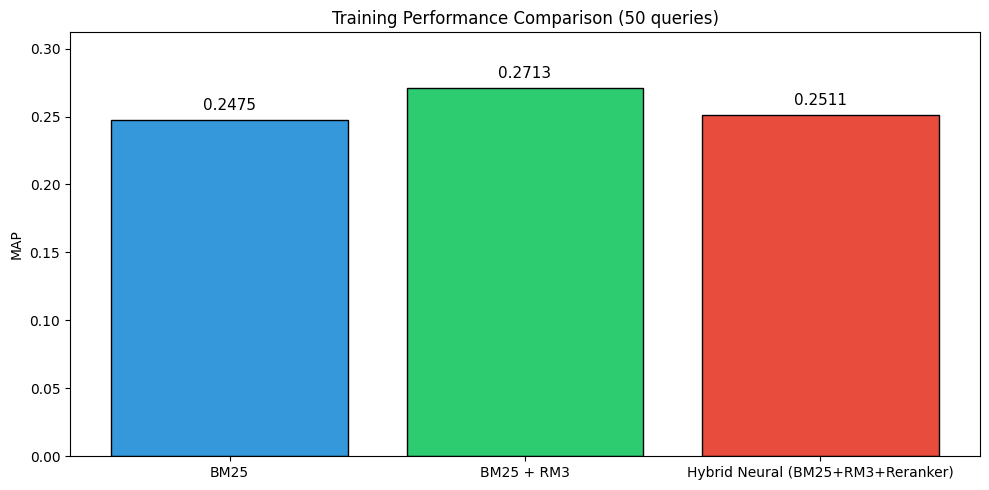


✓ All methods tuned and evaluated on training queries

→ Ready to generate submission files for test queries


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

methods = summary["Method"].tolist()
maps = summary["MAP"].tolist()
colors = ["#3498db", "#2ecc71", "#e74c3c"]

bars = ax.bar(methods, maps, color=colors, edgecolor="black")
ax.set_ylabel("MAP")
ax.set_title("Training Performance Comparison (50 queries)")
ax.set_ylim(0, max(maps) * 1.15)

for bar, m in zip(bars, maps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{m:.4f}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ All methods tuned and evaluated on training queries")
print("\n→ Ready to generate submission files for test queries")

## 8. Generate Submission Files

---

**Final Step**: Using the best configurations from each phase, we generate predictions for the 199 test queries (without relevance judgments). Each method produces a TREC-formatted run file with 1000 ranked documents per query.

### 8.1. Run Inference on Test Queries

In [ ]:
print("="*80)
print(f"GENERATING SUBMISSION FILES: {len(test_queries)} test queries (no qrels)")
print("="*80)
print()

# Method 1: BM25 (Phase 1 best)
print("Run 1: BM25 (Phase 1 best)")
print(f"  Parameters: k1={best_k1}, b={best_b}")
run_1 = bm25_model.search(test_queries, k=1000)
print(f"  ✓ {len(run_1)} queries processed")

# Method 2: BM25 + RM3 (Phase 2 best)
print("\nRun 2: BM25 + RM3 (Phase 2 best)")
print(f"  Parameters: k1={best_k1}, b={best_b}, fb_terms={best_fb_terms}, fb_docs={best_fb_docs}, orig_w={best_orig_w}")
run_2 = rm3_model.search(test_queries, k=1000)
print(f"  ✓ {len(run_2)} queries processed")

# Method 3: Multi-Branch Pipeline (Phase 3 best)
print("\nRun 3: Multi-Branch + Neural PRF + MiniLM MaxP (Phase 3 best)")
print(f"  BM25/RM3: k1={best_k1}, b={best_b}, fb_terms={best_fb_terms}, fb_docs={best_fb_docs}, orig_w={best_orig_w}")
print(f"  Pipeline: rrf_k={best_rrf_k}, prf_fb_docs={best_prf_fb_docs}, prf_passages={best_prf_passages}")
print(f"  Reranking: rerank_k={best_rerank_k}, batch_size={best_batch_size}")
run_3 = multi_branch_model.search(test_queries, k=1000)
print(f"  ✓ {len(run_3)} queries processed")

print("\n✓ All test queries processed")

GENERATING SUBMISSION FILES: 199 test queries (no qrels)

Run 1: BM25 (Phase 1 best)
  Parameters: k1=0.6, b=0.4


BM25 Search: 100%|██████████| 199/199 [00:16<00:00, 12.07it/s]


  ✓ 199 queries processed

Run 2: BM25 + RM3 (Phase 2 best)
  Parameters: k1=0.6, b=0.4, fb_terms=20, fb_docs=15, orig_w=0.5


RM3 Search:  39%|███▊      | 77/199 [00:06<00:10, 11.10it/s]


KeyboardInterrupt: 

### 8.2. Export TREC Format

In [ ]:
def write_trec_run(
    run: Dict[str, List[Tuple[str, float]]],
    filepath: str,
    run_name: str
):
    """
    Write run to TREC format.
    Format: topic_id Q0 doc_id rank score run_name
    """
    with open(filepath, "w") as f:
        for qid in sorted(run.keys(), key=lambda x: int(x)):
            results = run[qid]
            # Sort by score descending
            sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
            for rank, (docid, score) in enumerate(sorted_results[:1000], start=1):
                f.write(f"{qid} Q0 {docid} {rank} {score:.6f} {run_name}\n")
    
    print(f"✓ Written: {filepath}")


print("Writing submission files...\n")

write_trec_run(run_1, "run_1.res", "run_1")
write_trec_run(run_2, "run_2.res", "run_2")
write_trec_run(run_3, "run_3.res", "run_3")

print("\n✓ All submission files written")

### 8.3. Validate Output

In [ ]:
def validate_run_file(filepath: str, expected_queries: int = 199, docs_per_query: int = 1000):
    """Validate TREC run file format and contents."""
    query_docs = defaultdict(list)
    
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split()
            qid, _, docid, rank, score, _ = parts
            query_docs[qid].append((int(rank), float(score)))
    
    # Check query count
    assert len(query_docs) == expected_queries, f"Expected {expected_queries} queries, got {len(query_docs)}"
    
    # Check docs per query and score ordering
    for qid, docs in query_docs.items():
        assert len(docs) == docs_per_query, f"Query {qid}: expected {docs_per_query} docs, got {len(docs)}"
        scores = [s for _, s in sorted(docs, key=lambda x: x[0])]
        assert scores == sorted(scores, reverse=True), f"Query {qid}: scores not in decreasing order"
    
    print(f"✓ {filepath}: {len(query_docs)} queries × {docs_per_query} docs, scores non-increasing")


print("Validating submission files...\n")

validate_run_file("run_1.res")
validate_run_file("run_2.res")
validate_run_file("run_3.res")

print("\n" + "="*60)
print("SUBMISSION FILES READY")
print("="*60)
print("Files: run_1.res, run_2.res, run_3.res")
print("Format: TREC 6-column")
print("="*60)